# PMAC presentation

**PO-1: increase total amount of service on the SHN and reliability of that service by 2024**

Typical weekday: 2/8/22

1. Routes on SHN
a. parallel routes (1 mi corridor) - how many routes, agencies, share of all CA transit agency-routes?
b. intersecting routes (everything not parallel) - how many routes, agencies, share of all CA transit agency-routes?
c. intersecting routes (not parallel, but actually travel on SHN (50 ft buffer) for some portion of that route) - subset of above, how many routes, agencies, share of all CA agency-routes?

2. How many routes on SHN, breakdown by district
3. How many service hours are scheduled for a typical weekday for (1)?
4. How many of these agencies that have parallel routes on SHN also have GTFS RT?
Use `isin` and find `itp_id`, not route-specific, because most agencies that provide GTFS RT do it for the majority of their routes.

In [1]:
#https://stackoverflow.com/questions/55162077/how-to-get-the-driving-distance-between-two-geographical-coordinates-using-pytho
import altair as alt
import altair_saver
import geopandas as gpd
import os
import pandas as pd

os.environ["CALITP_BQ_MAX_BYTES"] = str(130_000_000_000)

from calitp.tables import tbl
from calitp import query_sql
from siuba import *

from shared_utils import geography_utils, styleguide
from shared_utils import calitp_color_palette as cp 
import utils

alt.renderers.enable('altair_saver', fmts=['png'])
pd.options.display.float_format = '{:,}'.format

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [ ]:
'''
SELECTED_DATE = "2022-2-8"

trip_cols = ["calitp_itp_id", "calitp_url_number", "route_id", "shape_id"]


dim_trips = (tbl.views.gtfs_schedule_dim_trips()
             >> select(*trip_cols, _.trip_key)
             >> distinct()
            )

trips = (tbl.views.gtfs_schedule_fact_daily_trips()
         >> filter(_.service_date == SELECTED_DATE, 
                   _.is_in_service==True)
         >> select(_.trip_key, _.service_date, _.service_hours)
         >> inner_join(_, dim_trips, on = "trip_key")
         >> group_by(_.calitp_itp_id, _.calitp_url_number, _.shape_id, _.route_id)
         >> mutate(total_service_hours = _.service_hours.sum())
         >> select(*trip_cols, _.total_service_hours)
         >> distinct()
         >> rename(itp_id = "calitp_itp_id")
         >> collect()
        )
'''

In [2]:
#trips.to_parquet("./data/trips_service_hours.parquet")
trips = pd.read_parquet(f"{utils.DATA_PATH}trips_service_hours.parquet")
trips.head(2)

,itp_id,calitp_url_number,route_id,shape_id,total_service_hours
0,4,1,650,shp-650-08,0.8166666666666667
1,16,0,50,5607_shp,7.3999999999999995


In [3]:
trips2 = utils.include_exclude_multiple_feeds(trips, id_col = "itp_id",
                                     include_ids = [182],
                                     exclude_ids = [200]
                                    )

# obs in original df: 10211
# obs in new df: 7887
These operators have multiple calitp_url_number values: [56, 61, 106, 110, 127, 167, 182, 194, 246, 247, 264, 279, 280, 282, 290, 294, 314, 315, 350, 356, 368]


Now pull out service hours for parallel routes using `shape_id`.

Caveat:
* There are probably some `shape_ids` we can't find in January `routes_assembled`
* Can either exclude and they are not parallel, just count as intersecting for the all intersecting.
* Or, can go back to `gtfs_schedule.shapes` to see if it can be found, and determine whether it's parallel or not
* Finding it in `gtfs_schedule.shapes` can be iffy because it's always current, and we are setting a typical weekday in the past. We still may not find all of it. It may be a closer estimate, but excluding them from being parallel maybe is a cleaner approach, and allows us to treat edge cases the same.


### Rerun routes_assembled

Do it with `gtfs_schedule.shapes` because we're losing quite a bit of routes, even when it's parallel. 

1. Make new `routes_assembled`
1. Run the new `routes_assembled` through `create_parallel_corridors` to tag parallel
routes with 1 mile buffer
1. Run new `routes_assembled` through to tag parallel corridors with 50 ft buffer to grab intersecting subset
1. Grab service hours for parallel, intersecting subset, other intersecting (not parallel). Together, this should be 100%

**Run routes assembled for 3/2/22** ..hope this matches better than Jan against the 2/8/22 service date. Conclusion: it doesn't, so let's just exclude `shape_id` and use `route_id`, because that's slightly more aggregate, and those should be way more consistent.

Build a file that is all routes, and flags it if it is parallel, somewhat intersects SHN, and not parallel. 3 groups are mutually exclusive.

In [4]:
df = geography_utils.aggregate_by_geography(
    trips2,
    group_cols = ["itp_id" , "route_id"],
    # this is a choice to sum up service hours if they have same route_id
    # but different shape_id
    sum_cols = ["total_service_hours"]
)

In [5]:
def flag_parallel_intersecting_routes(df):
    # If it is parallel, we want to flag as 1
    parallel = gpd.read_parquet(
        f"{utils.DATA_PATH}parallel_or_intersecting_2022-03-02.parquet")
    
    # Attach district info for routes, wherever possible
    df = pd.merge(df,
                  (parallel[["itp_id", "route_id", "District"]]
                   .astype({"District": "Int64"})
                  .drop_duplicates(subset=["itp_id", "route_id"])),
                  on = ["itp_id", "route_id"],
                  how = "left",
                  validate = "1:1"
                 )
    
    parallel = parallel[parallel.parallel==1]
    
    # These are routes that have some part on SHN
    # BUT, there is overlap between the parallel
    # Since the requirements here are less stringent than parallel
    # So, remove those that are already parallel
    on_shn = gpd.read_parquet(
        f"{utils.DATA_PATH}routes_on_shn_2022-03-02.parquet"
    )
    
    # Get it down to unique route (instead of with highway info)
    def get_unique_routes(df):
        # If there are multiple shape_ids for route_id,
        # Keep the one where it's has higher overlap with SHN
        df = (df.sort_values(["itp_id", "route_id", "pct_route", "shape_id"],
                             ascending=[True, True, False, True],
                            )
                    .drop_duplicates(subset=["itp_id", "route_id"])
                    [["itp_id", "route_id", "parallel"]]
                    .reset_index(drop=True)
                   )
        return df
    
    parallel2 = get_unique_routes(parallel)
    on_shn2 = get_unique_routes(on_shn)
    on_shn2 = on_shn2.assign(
        on_shn = 1,
    ).drop(columns = "parallel")
    
    m1 = pd.merge(df, 
                  parallel2,
                  on = ["itp_id", "route_id"],
                  how = "left",
                  validate = "1:1"
    )
    
    m2 = pd.merge(m1,
                  on_shn2,
                  on = ["itp_id", "route_id"],
                  how = "left",
                  validate = "1:1"
    )

    return m2

In [6]:
def mutually_exclusive_groups(df):
    # Now, force mutual exclusivity
    def make_mutually_exclusive(row):
        if row.parallel==1:
            return "parallel"
        elif row.on_shn==1:
            return "on_shn"
        else:
            return "other"
    
    df["category"] = df.apply(lambda x: make_mutually_exclusive(x), axis=1)
    
    df2 = df.assign(
        is_parallel = df.apply(lambda x: 
                               1 if x.category == "parallel" else 0, axis=1),
        is_on_shn = df.apply(lambda x: 
                             1 if x.category == "on_shn" else 0, axis=1),
        is_other = df.apply(lambda x: 
                            1 if x.category == "other" else 0, axis=1),
        # Create a column that can be summed across categories
        # since group_col will include category, and nunique(route_id) double-counts
        unique_route = 1
    ).drop(columns = ["parallel", "on_shn"])
    
    return df2

In [7]:
df = flag_parallel_intersecting_routes(df)
df = mutually_exclusive_groups(df)

In [8]:
# I think this is the initial table
# Get it summarized to # and %
summary = geography_utils.aggregate_by_geography(
    df, 
    group_cols = ["category"],
    sum_cols = ["total_service_hours", "unique_route"],
)

In [9]:
# Add percents
def add_percent(df, col_list):
    for c in col_list:
        new_col = f"pct_{c}"
        df[new_col] = (df[c] / df[c].sum()).round(3) * 100
        df[c] = df[c].round(0)
        
    return df

# route_id....well, unique route_id is not exactlyy the same as is_parallel,
# is_on_shn, is_other
# Maybe stick with that to be consistent
#add_percent(t1, "route_id")

In [10]:
summary = add_percent(summary, ["total_service_hours", "unique_route"])

col_order = ['category', 'unique_route', 'pct_unique_route',
             'total_service_hours', 'pct_total_service_hours'
            ]

summary[col_order]

,category,unique_route,pct_unique_route,total_service_hours,pct_total_service_hours
0,parallel,1873,66.9,"54,480.0",55.1
1,on_shn,620,22.2,"14,389.0",14.6
2,other,305,10.9,"30,020.0",30.4


In [11]:
geography_utils.aggregate_by_geography(
    summary.assign(category="All"),
    group_cols = ["category"],
    sum_cols = ["unique_route", "total_service_hours"]
)

,category,total_service_hours,unique_route
0,All,"98,889.0",2798


In [12]:
# Where district is missing, it's not parallel routes
# So let's ignore those sections and focus on just parallel and do breakdown
df[(df.District.isna())].category.value_counts()

other     305
on_shn     64
Name: category, dtype: int64

In [13]:
by_district = geography_utils.aggregate_by_geography(
    df[df.category=="parallel"],
    group_cols = ["District"],
    sum_cols = ["total_service_hours", "unique_route"]
)

by_district = (add_percent(by_district, ["total_service_hours", "unique_route"])
               .sort_values("District")
              )

for c in ["pct_total_service_hours", "pct_unique_route"]:
    by_district[c] = by_district[c].round(1)
    
by_district

,District,total_service_hours,unique_route,pct_total_service_hours,pct_unique_route
4,1,685.0,57,1.3,3.0
7,2,417.0,45,0.8,2.4
2,3,"2,215.0",142,4.1,7.6
0,4,"25,825.0",708,47.4,37.8
9,5,"1,419.0",89,2.6,4.8
6,6,"1,296.0",70,2.4,3.7
1,7,"10,187.0",404,18.7,21.6
5,8,"2,032.0",76,3.7,4.1
8,9,208.0,20,0.4,1.1
3,10,"1,193.0",82,2.2,4.4


In [14]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Raleway');
@import url('https://fonts.googleapis.com/css?family=Nunito+Sans');
@import url('https://fonts.googleapis.com/css?family=Bitter');
</style>

In [20]:
def base_bar(df):
    chart = (alt.Chart(df)
             .mark_bar()
             .encode(
                 x=alt.X("District:N", title="District")
             )
            )
    return chart

def make_bar(df, y_col):
    
    y_title = f"{y_col.replace('_', ' ').title()}"
    
    bar = base_bar(df)
    
    bar = (bar.encode(
        y=alt.Y(f"{y_col}:Q", title=f"{y_title}"),
        color=alt.Color("District:N", 
                        scale=alt.Scale(
                            range=cp.CALITP_CATEGORY_BRIGHT_COLORS
                        )
                )
             )
            )
    #https://stackoverflow.com/questions/54015250/altair-setting-constant-label-color-for-bar-chart
    text = (bar
            .mark_text(align="center", baseline="bottom",
                       color="black", dy=-5  
                      )
            .encode(text=y_col, 
                    # Set color here, because encoding for mark_text gets 
                    # superseded by alt.Color
                   color=alt.value("black"))
    )
      
    chart = (bar+text)
    
    chart = (styleguide.preset_chart_config(chart)
             .properties(title= {
                 "text": f"{y_title} by District",
                 "subtitle": "Parallel Routes"
            }).configure_axis(grid=False)
            )
    
    chart.save(f"{utils.IMG_PATH}pmac_{y_col}.png")
    
    display(chart)

SyntaxError: invalid syntax (2539471505.py, line 39)

In [16]:
by_district = by_district.assign(
    avg_service_hours = by_district.total_service_hours.divide(
        by_district.unique_route).round(1)
)

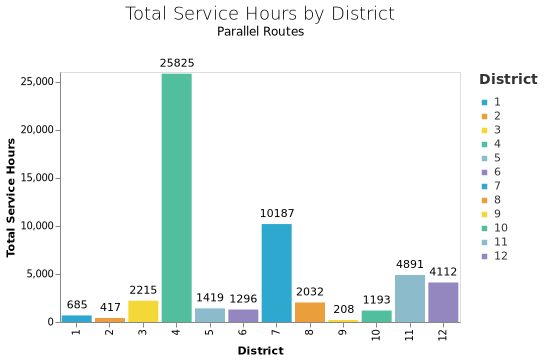

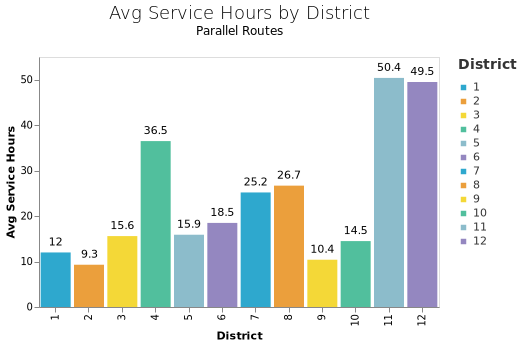

In [19]:
metrics = [
    "total_service_hours", 
    #"unique_route", 
    "avg_service_hours"
]

for m in metrics:
    make_bar(by_district, m)